In [1]:
from utils import *
from trimesh import *
from optimal import OptimalSWF
from swf import *
from constants import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
base704 = OptimalSWF(vertices704,faces704,2).model 

#transcoding mesh 
key = transcoding_precomputed_coeffs
base = Trimesh(v_3_0,f_3_0,ALPHA=key[0][0],BETA=key[0][1],GAMMA=key[0][2])
first = base.manual_subdivide(v_5_0,f_5_0,ALPHA=key[1][0],BETA=key[1][1],GAMMA=key[1][2])
second = first.manual_subdivide(v_5_2,f_5_2,ALPHA=key[2][0],BETA=key[2][1],GAMMA=key[2][2])
third = second.manual_subdivide(v_7_4,f_7_4,ALPHA=key[3][0],BETA=key[3][1],GAMMA=key[3][2])
fourth = third.manual_subdivide(v_9_6,f_9_6,ALPHA=key[4][0],BETA=key[4][1],GAMMA=key[4][2])
fifth = fourth.manual_subdivide(v_11_8,f_11_8,ALPHA=key[5][0],BETA=key[5][1],GAMMA=key[5][2])
opt_meshset = [first,second,third,fourth,fifth]
transcoding = SWF(base,2,meshset=opt_meshset)

In [3]:
theta = np.linspace(0,2*np.pi,48000) #48000 samples of a circular panning 
x = np.cos(theta) #x component of the circular panning 
y = np.sin(theta) #y component of the circular panning 

horizontalPanning = np.vstack((x,y,np.zeros(theta.shape[0]))).T #the unit circle in R3 w/ z=0

In [4]:
pressure704 = np.array([base704.total_acoustic_pressure(i) for i in horizontalPanning])
pressuretrans = np.array([transcoding.total_acoustic_pressure(i,3) for i in horizontalPanning])

energy704 = np.array([base704.energy(i) for i in horizontalPanning])
energytrans = np.array([transcoding.energy(i,3) for i in horizontalPanning])

velocity704 = np.array([base704.velocity(i) for i in horizontalPanning])
velocitytrans = np.array([transcoding.velocity(i,3) for i in horizontalPanning])

intensity704 = np.array([base704.intensity(i) for i in horizontalPanning])
intensitytrans = np.array([transcoding.intensity(i,3) for i in horizontalPanning])

In [5]:
encoded704 = np.empty((11,0))
encodedtrans = np.empty((11,0))
for i in horizontalPanning:
    fine = base704.interpolate(i)
    coarse = base704.encode(fine,0)
    encoded704 = np.append(encoded704,coarse,axis=1)

    fine = transcoding.interpolate(i)
    coarse = transcoding.encode(fine,3)
    encodedtrans = np.append(encodedtrans,coarse,axis=1)

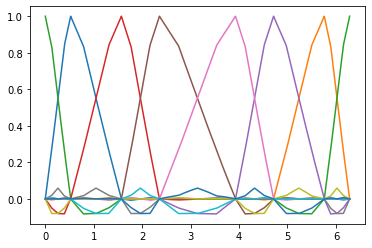

In [6]:
for i in range(11):
    plt.plot(theta,encoded704[i])

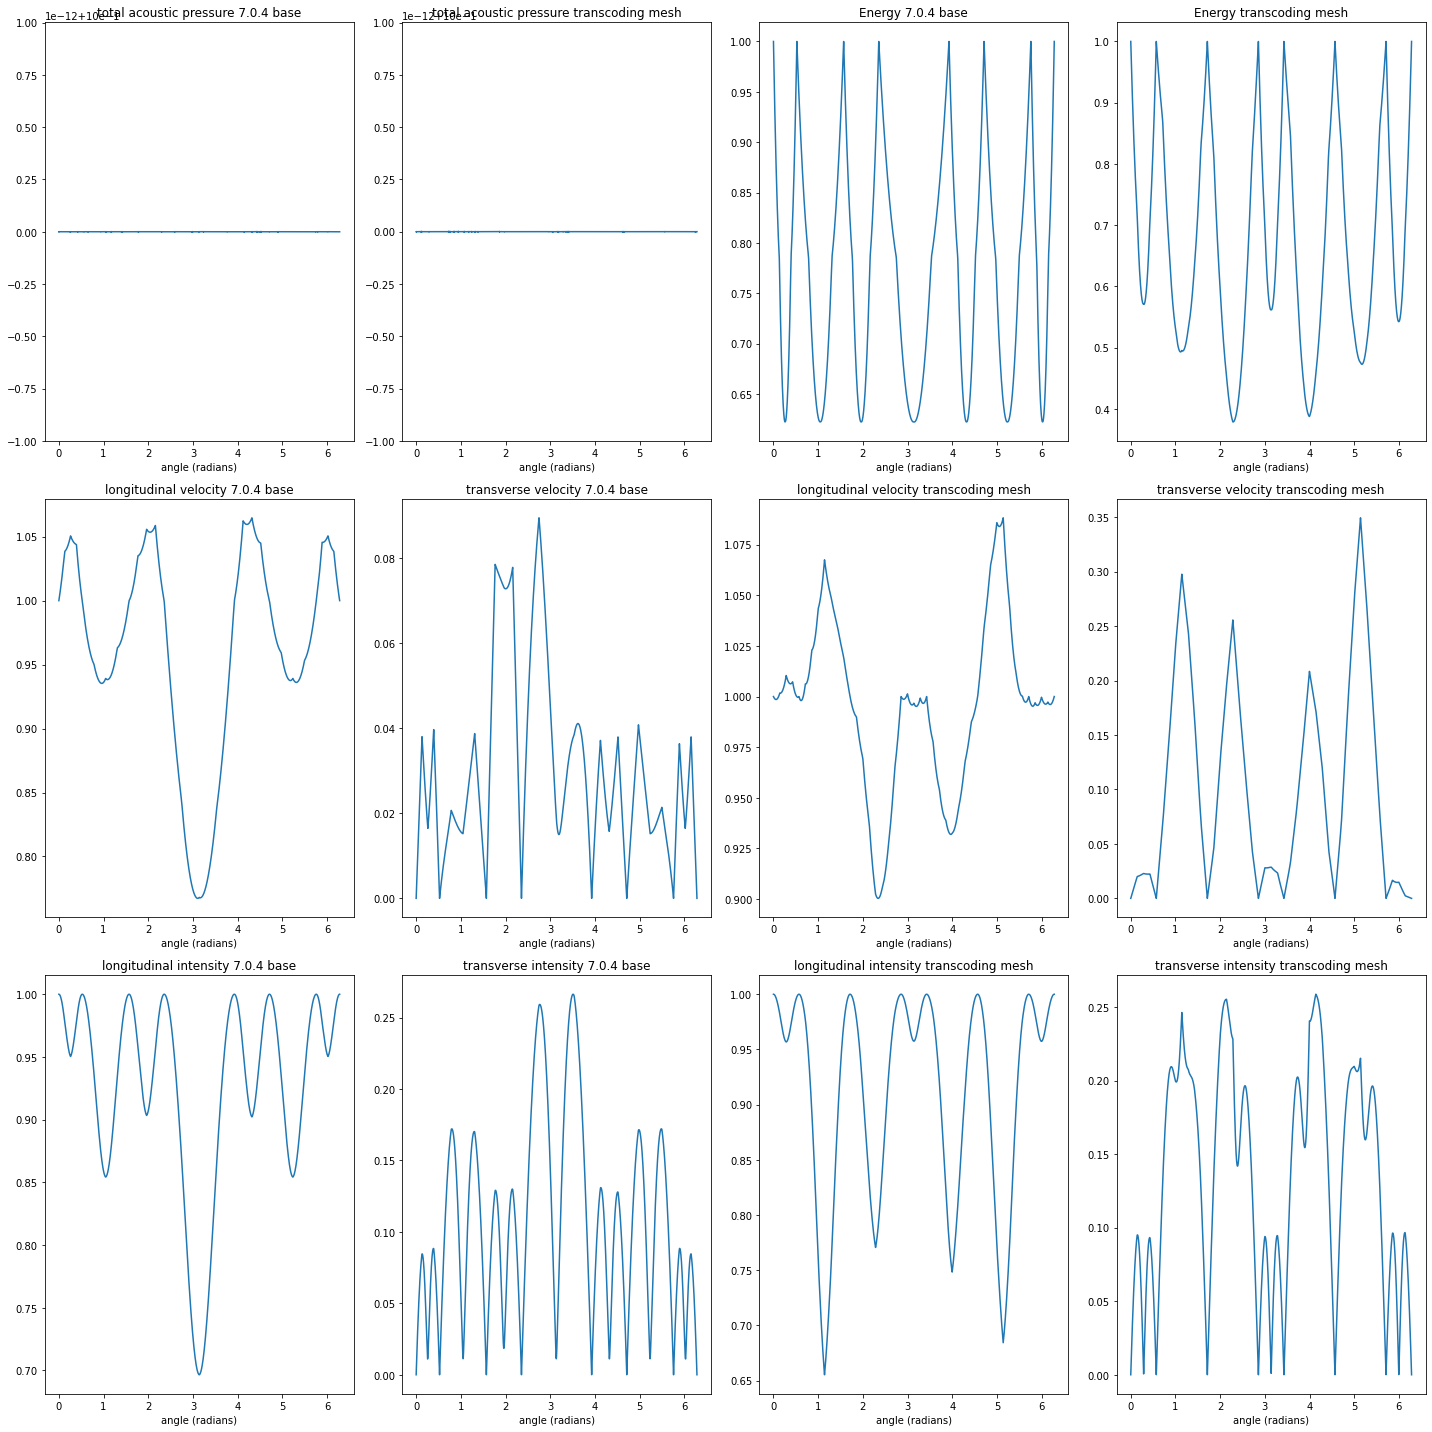

In [7]:
fig, subplots = plt.subplots(3,4,figsize=(20,20))

subplots[0,0].plot(theta,pressure704)
subplots[0,0].set_title('total acoustic pressure 7.0.4 base')
subplots[0,1].plot(theta,pressuretrans)
subplots[0,1].set_title('total acoustic pressure transcoding mesh')
subplots[0,2].plot(theta,energy704)
subplots[0,2].set_title('Energy 7.0.4 base')
subplots[0,3].plot(theta,energytrans)
subplots[0,3].set_title('Energy transcoding mesh')

subplots[1,0].plot(theta,velocity704[:,0])
subplots[1,0].set_title('longitudinal velocity 7.0.4 base')
subplots[1,1].plot(theta,velocity704[:,1])
subplots[1,1].set_title('transverse velocity 7.0.4 base')
subplots[1,2].plot(theta,velocitytrans[:,0])
subplots[1,2].set_title('longitudinal velocity transcoding mesh')
subplots[1,3].plot(theta,velocitytrans[:,1])
subplots[1,3].set_title('transverse velocity transcoding mesh')
                             
subplots[2,0].plot(theta,intensity704[:,0])
subplots[2,0].set_title('longitudinal intensity 7.0.4 base')
subplots[2,1].plot(theta,intensity704[:,1])
subplots[2,1].set_title('transverse intensity 7.0.4 base')
subplots[2,2].plot(theta,intensitytrans[:,0])
subplots[2,2].set_title('longitudinal intensity transcoding mesh')
subplots[2,3].plot(theta,intensitytrans[:,1])
subplots[2,3].set_title('transverse intensity transcoding mesh')

for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    
fig.tight_layout()

In [8]:
def VBAP(loc,mesh):
        '''
        VBAP-style interpolation over the mesh
        '''
        loc = loc.reshape((-1,3))
        triangles = mesh.vertices[mesh.faces]
        closest, dist, ind = mesh.closest_point_naive(loc)

        PQR = triangles[ind]
    
        AreaPQR = AreaTRI(PQR) #Area of PQR

        PQ = PQR[:,1] - PQR[:,0] #get the PQ vector of the triangle PQR
        PR = PQR[:,2] - PQR[:,0] #get the PR vector of the triangle PQR
        normals = np.cross(PQ,PR) #get the normal vector for the plane defined by the triangle PQR
        unitNormals = normals/np.linalg.norm(normals,axis=1).reshape(-1,1) #normal vector of unit length defined by PQR
        scalarDist = np.sum(unitNormals*(loc-PQR[:,0,:]),axis=1) #scalar distance from panning point to plane along the normal
        projection = loc - scalarDist.reshape(-1,1)*unitNormals #projection of panning point onto the plane defined by triangle PQR

        S = projection.reshape(-1,1,3) #reshaped for use in the area calculations

        SQR = np.hstack((S,PQR[:,1:,:])) #The triangle SQR defined by the panning point S and its two furthest neighbors
        PSR = np.hstack((PQR[:,0,:].reshape(-1,1,3),S,PQR[:,2,:].reshape(-1,1,3))) #The triangle PSR defined by S and its closest and furthest neighbors
        PQS = np.hstack((PQR[:,:2,:],S)) #The triangle PQS defined by S and its two closest neighbors

        AreaSQR = AreaTRI(SQR) #area of SQR
        AreaPSR = AreaTRI(PSR) #area of PSR
        AreaPQS = AreaTRI(PQS) #area of PQS

        interpolation = np.vstack((AreaSQR/AreaPQR,AreaPSR/AreaPQR,AreaPQS/AreaPQR)).T 
        interpolation = interpolation/interpolation.sum(axis=1).reshape(-1,1)
        
        fine = np.zeros((mesh.vertices.shape[0],1)) 
        fine[mesh.faces[ind]] = interpolation.reshape((1,3,1))
        
        return fine

In [13]:
vbap704 = np.empty((11,0))
mesh = Trimesh(vertices704,faces704)
for i in horizontalPanning:
    vbap704 = np.append(vbap704,VBAP(i,mesh),axis=1)

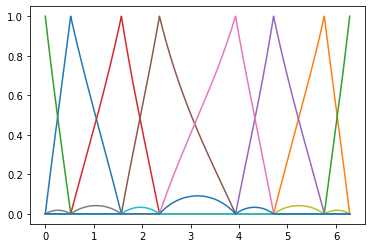

In [15]:
for i in range(11):
    plt.plot(theta,vbap704[i])